<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/main/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install optuna --quiet

     |████████████████████████████████| 266kB 17.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 37.2MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 133kB 50.6MB/s 
     |████████████████████████████████| 112kB 55.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 


In [3]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 
import optuna

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

In [7]:
import numba

# Get Dataset

In [4]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4139 (delta 0), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4139/4139), 878.77 MiB | 37.70 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Checking out files: 100% (2011/2011), done.


In [12]:
ROOT = '/content/ESC-50/audio'

audio_list = []
for audio in Path(ROOT).iterdir():
    try:
        sr, this_sound = wavfile.read(audio)
        audio_list.append(this_sound/32768)     #put in [-1,+1]
    except:
        print('cannot read ', str(audio))

print(len(audio_list))

print(np.shape(audio))
# audio_arr = np.array(audio_list)
# print(np.max(audio_arr), np.min(audio_arr))
#need normalization? insiede Sequence



2000
()


In [20]:
data_csv = pd.read_csv("/content/ESC-50/meta/esc50.csv")
data_csv

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [ ]:
colnames = ['filename','fold','target','category','esc10','src_file','take']
csv = pd.read_csv('/content/ESC-50/meta/esc50.csv', header=0)
label_list = csv.target.tolist()
fold_list = csv.fold.tolist()
category_list = csv.category.tolist()
name_list = csv.filename.tolist()

print(label_list)
print(fold_list)

label = np.float32(np.array(label_list))
fold = np.float32(np.array(fold_list))
class_dict = dict(zip(label_list, category_list))

print(class_dict)

In [13]:
print(audio_list[0])

[-0.11691284  0.09646606  0.10412598 ... -0.28704834 -0.41384888
 -0.34429932]


# Try first with very basic preprocessing and classification
without kfold or slicing

In [41]:
#try parallelization
def melSpect(audio_list, n):
    audio_mel = []
    for i in notebook.tqdm(range(n)):
        audio_mel.append(librosa.amplitude_to_db(librosa.feature.melspectrogram(audio_list[i], sr=sr, n_mels=60 )))
    return audio_mel
audio_mel = melSpect(audio_list, len(audio_list))
print(type(audio_mel[0]))
print(np.shape(audio_mel[0]))


<class 'numpy.ndarray'>
(60, 431)


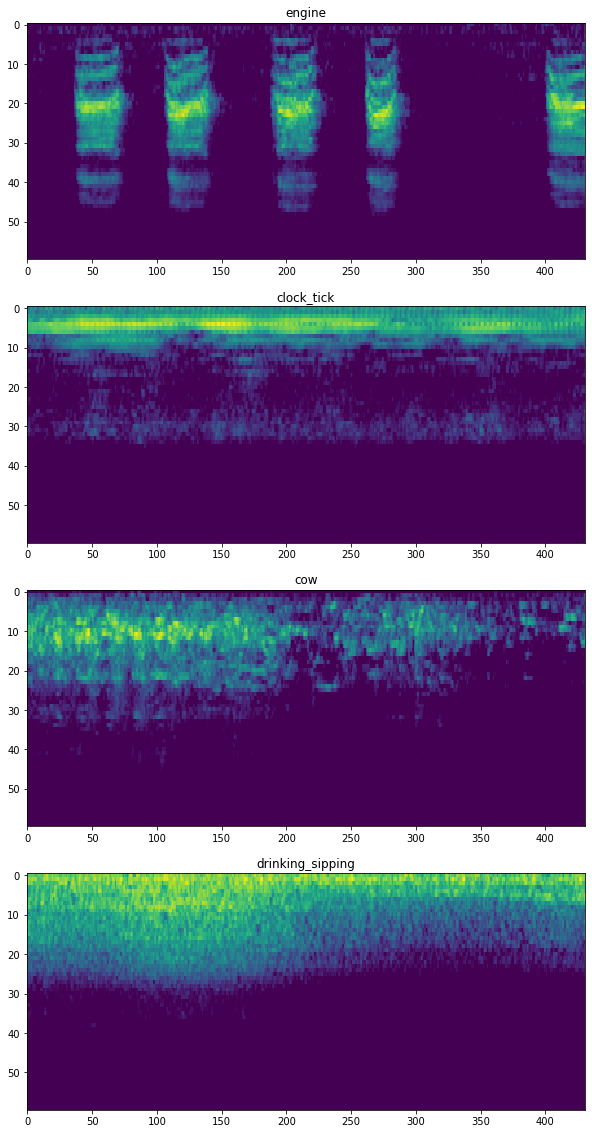

In [43]:
fig, ax = plt.subplots(4,1,figsize=(10,20))
for i in range(4):
    sample = int(np.random.uniform()*len(audio_list))
    ax[i].imshow(audio_mel[sample], interpolation='nearest', aspect='auto')
    ax[i].set_title(data_csv['category'][sample])
